In [1]:
!pip install plotly==5.6.0

     |████████████████████████████████| 27.7 MB 8.5 MB/s            


In [2]:
!pip install shapely

     |████████████████████████████████| 2.0 MB 8.1 MB/s            


In [3]:
!pip install intake-geopandas

     |████████████████████████████████| 1.0 MB 7.8 MB/s            
     |████████████████████████████████| 1.5 MB 46.1 MB/s            
     |████████████████████████████████| 16.7 MB 54.7 MB/s            
     |████████████████████████████████| 6.3 MB 45.3 MB/s            
     |████████████████████████████████| 136 kB 44.3 MB/s            
     |████████████████████████████████| 1.1 MB 52.0 MB/s            
     |████████████████████████████████| 596 kB 47.5 MB/s            
     |████████████████████████████████| 96 kB 19.1 MB/s            
     |████████████████████████████████| 55 kB 12.0 MB/s            


In [4]:
#%% Module
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pathlib

# Import functions
from netopt import netopt, print_solution, plot_map
from data_structures import (show_data, set_capacity, set_all_capacities, set_fixed_cost,
                             set_all_fixed_costs, scale_demand, scale_all_demands, set_demand,
                             set_all_demands, calculate_dm)
import shapely
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, MultiPolygon

# Import data
# The variable customers_as_is contains the existing customers, while the variable customers_to_be contains both
# existing and prospective customers
# The variable warehouses contains all the candidate locations, including the existing one (Bologna, id 6)

from data.projectwork_data import warehouses, customers_as_is, customers_to_be

In [12]:
cur_customer = pd.read_excel('datasets_csv/CurrentCustomers.xlsx')
print(cur_customer)

    Unnamed: 0  Id          Identifier                City  Latitude  \
0            0   0               Milan               Milan   45.4669   
1            1   1               Turin               Turin   45.0667   
2            2   2               Genoa               Genoa   44.4072   
3            3   3             Bologna             Bologna   44.4939   
4            4   4              Venice              Venice   45.4397   
5            5   5              Verona              Verona   45.4386   
6            6   6              Padova              Padova   45.4064   
7            7   7             Trieste             Trieste   45.6503   
8            8   8             Brescia             Brescia   45.5389   
9            9   9               Parma               Parma   44.8015   
10          10  10              Modena              Modena   44.6458   
11          11  11       Reggio Emilia       Reggio Emilia   44.7000   
12          12  12             Ravenna             Ravenna   44.

In [11]:
new_customer = pd.read_excel('datasets_csv/ProspectiveCustomers.xlsx')
print(new_customer)

    Unnamed: 0  Id             Identifier                   City  Latitude  \
0           31  31                   Rome                   Rome   41.8931   
1           32  32                 Naples                 Naples   40.8333   
2           33  33                Palermo                Palermo   38.1157   
3           34  34               Florence               Florence   43.7714   
4           35  35                   Bari                   Bari   41.1253   
5           36  36                Catania                Catania   37.5027   
6           37  37                Messina                Messina   38.1936   
7           38  38                Taranto                Taranto   40.4181   
8           39  39                  Prato                  Prato   43.8808   
9           40  40     Reggio di Calabria     Reggio di Calabria   38.1144   
10          41  41                Perugia                Perugia   43.1121   
11          42  42                Livorno                Livorno

In [7]:
loc_warehouse = pd.read_excel('datasets_csv/CandidateLocations.xlsx')
print(loc_warehouse.head)

<bound method NDFrame.head of     Unnamed: 0  Id          Identifier                City  Latitude  \
0            0   0                Rome                Rome   41.8931   
1            1   1               Milan               Milan   45.4669   
2            2   2              Naples              Naples   40.8333   
3            3   3               Turin               Turin   45.0667   
4            4   4             Palermo             Palermo   38.1157   
5            5   5               Genoa               Genoa   44.4072   
6            6   6             Bologna             Bologna   44.4939   
7            7   7            Florence            Florence   43.7714   
8            8   8                Bari                Bari   41.1253   
9            9   9             Catania             Catania   37.5027   
10          10  10              Venice              Venice   45.4397   
11          11  11              Verona              Verona   45.4386   
12          12  12              An

In [20]:
Bologna_warehouse = pd.DataFrame(loc_warehouse.iloc[6:7])
print(Bologna_warehouse.head())

   Unnamed: 0  Id Identifier     City  Latitude  Longitude  \
6           6   6    Bologna  Bologna   44.4939    11.3428   

   Max yearly capacity  Yearly fixed cost  
6                 7000              60000  


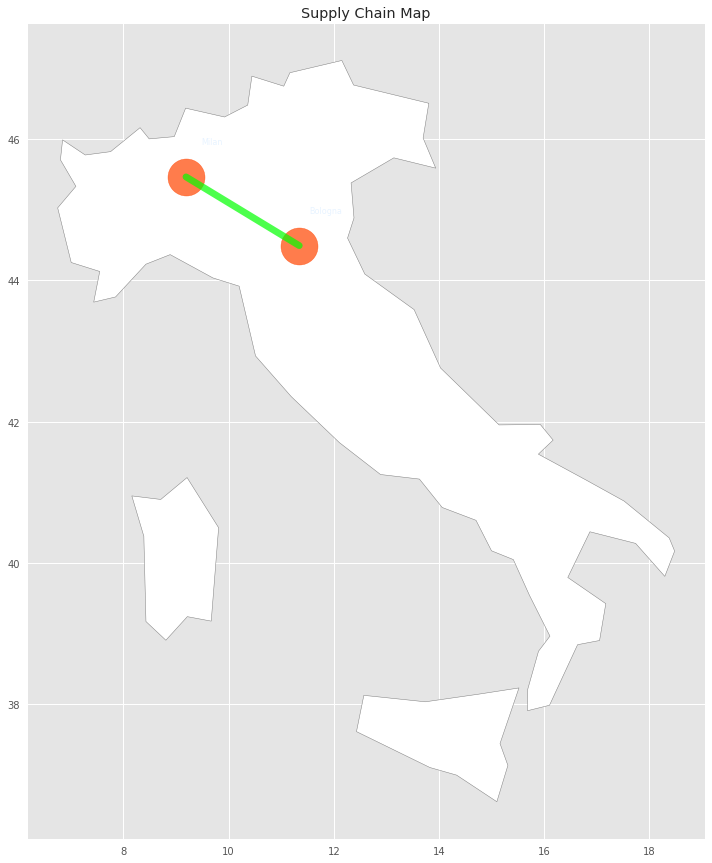

In [21]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world.head()

with plt.style.context(("seaborn", "ggplot")):
    ## Plot world
    world[world.name == "Italy"].plot(figsize=(15,15), edgecolor="grey", color="white");

    ## Loop through each flight plotting line depicting flight between source and destination
    for slat, dlat, slon, dlon, num_flights, src_city, dest_city in zip(Bologna_warehouse["Latitude"], cur_customer["Latitude"], Bologna_warehouse["Longitude"], cur_customer["Longitude"], cur_customer["Demand"], Bologna_warehouse["City"], cur_customer["City"]):
        plt.plot([slon , dlon], [slat, dlat], linewidth=num_flights/200, color="lime", alpha=0.7)
        plt.scatter( [slon, dlon], [slat, dlat], color="orangered", alpha=0.7, s=num_flights)

        plt.text(slon+0.5, slat+0.5, src_city, fontsize=8, color="dodgerblue", alpha=0.1, horizontalalignment='center', verticalalignment='center')
        plt.text(dlon+0.5, dlat+0.5, dest_city, fontsize=8, color="dodgerblue", alpha=0.1, horizontalalignment='center', verticalalignment='center')

    plt.title("Connection Map Depicting Flights between Cities of Brazil")

    #plt.savefig("connection-map-geopandas-5.png", dpi=100)
        

    plt.title("Supply Chain Map")

In [32]:
# Bologna --> initial customers

line_point = LineString([(11.3428,44.4939),(11.3429,44.4938)]) #bologna
line0 = LineString([(11.3428,44.4939),(9.1900,45.4669)])
line1 = LineString([(11.3428,44.4939),(7.7000,45.0667)])
line2 = LineString([(11.3428,44.4939),(8.9340,44.4072)])
line3 = LineString([(11.3428,44.4939),(12.3319,45.4397)])
line4 = LineString([(11.3428,44.4939),(10.9928,45.4386)])   
line5 = LineString([(11.3428,44.4939),(11.8778,45.4064)])   
line6 = LineString([(11.3428,44.4939),(13.7703,45.6503)])   
line7 = LineString([(11.3428,44.4939),(10.2203,45.5389)])                         
line8 = LineString([(11.3428,44.4939),(10.3280,44.8015)])   
line9 = LineString([(11.3428,44.4939),(10.9257,44.6458)])   
line10 = LineString([(11.3428,44.4939),(10.6333,44.7000)])   
line11 = LineString([(11.3428,44.4939),(12.1994,44.4178)])   
line12 = LineString([(11.3428,44.4939),(11.6199,44.8353)])   
line13 = LineString([(11.3428,44.4939),(9.2736,45.5836)])   
line14 = LineString([(11.3428,44.4939),(9.6700,45.6950)])   
line15 = LineString([(11.3428,44.4939),(11.1167,46.0667)])                          
line16 = LineString([(11.3428,44.4939),(11.5500,45.5500)])   
line17 = LineString([(11.3428,44.4939),(11.3500,46.5000)])   
line18 = LineString([(11.3428,44.4939),(8.6167,45.4500)])   
line19 = LineString([(11.3428,44.4939),(9.7000,45.0500)])   
line20 = LineString([(11.3428,44.4939),(13.2333,46.0667)])   
line21 = LineString([(11.3428,44.4939),(8.6200,44.9133)])   
line22 = LineString([(11.3428,44.4939),(12.2381,45.4906)])   
line23 = LineString([(11.3428,44.4939),(12.2422,45.6722)])                   
line24 = LineString([(11.3428,44.4939),(8.8518,45.6120)])   
line25 = LineString([(11.3428,44.4939),(9.0861,45.8103)])   
line26 = LineString([(11.3428,44.4939),(9.2333,45.5333)])   
line27 = LineString([(11.3428,44.4939),(8.8333,45.8167)])   
line28 = LineString([(11.3428,44.4939),(8.2069,44.9000)])   
line29 = LineString([(11.3428,44.4939),(9.2167,45.5500)])

po_x,po_y = line_point.coords.xy
x0,y0 = line0.coords.xy
x1,y1 = line1.coords.xy
x2,y2 = line2.coords.xy
x3,y3 = line3.coords.xy
x4,y4 = line4.coords.xy
x5,y5 = line5.coords.xy
x6,y6 = line6.coords.xy
x7,y7 = line7.coords.xy
x8,y8 = line8.coords.xy
x9,y9 = line9.coords.xy
x10,y10 = line10.coords.xy
x11,y11 = line11.coords.xy
x12,y12 = line12.coords.xy
x13,y13 = line13.coords.xy
x14,y14 = line14.coords.xy
x15,y15 = line15.coords.xy
x16,y16 = line16.coords.xy
x17,y17 = line17.coords.xy
x18,y18 = line18.coords.xy
x19,y19 = line19.coords.xy
x20,y20 = line20.coords.xy
x21,y21 = line21.coords.xy
x22,y22 = line22.coords.xy
x23,y23 = line23.coords.xy
x24,y24 = line24.coords.xy
x25,y25 = line25.coords.xy
x26,y26 = line26.coords.xy
x27,y27 = line27.coords.xy
x28,y28 = line28.coords.xy
x29,y29 = line29.coords.xy



#warehouse1 (genova) --> #new customers

wc_genova = LineString([(8.9340,44.4072),(8.9340,44.4072)]) #genova
wc11 = LineString([(8.9340,44.4072),(9.0861,45.8103)])
wc12 = LineString([(8.9340,44.4072),(9.2333,45.5333)])
wc13 = LineString([(8.9340,44.4072),(8.8333,45.8167)])
wc14 = LineString([(8.9340,44.4072),(8.2069,44.9000)])
wc15 = LineString([(8.9340,44.4072),(9.2167,45.5500)])

po_x_genova,po_y_genova = wc_genova.coords.xy
wc11x, wc11y = wc11.coords.xy
wc12x, wc12y = wc12.coords.xy
wc13x, wc13y = wc13.coords.xy
wc14x, wc14y = wc14.coords.xy
wc15x, wc15y = wc15.coords.xy


#warehouse2 (bologna)  --> #new

wc21 = LineString([(11.3428,44.4939),(12.4828,41.8931)])
wc22 = LineString([(11.3428,44.4939),(7.7000,45.0667)])
wc23 = LineString([(11.3428,44.4939),(11.1089,42.7722)]) 
wc24 = LineString([(11.3428,44.4939),(12.3319,45.4397)])
wc25 = LineString([(11.3428,44.4939),(10.9928,45.4386)])

wc21x, wc21y = wc21.coords.xy
wc22x, wc22y = wc22.coords.xy
wc23x, wc23y = wc23.coords.xy
wc24x, wc24y = wc24.coords.xy
wc25x, wc25y = wc25.coords.xy


#warehouse3 (napoli) --> #new

wc_napoli = LineString([(14.2500,40.8333),(14.2500,40.8333)]) #napoli
wc31 = LineString([(14.2500,40.8333),(15.5542,38.1936)])
wc32 = LineString([(14.2500,40.8333),(17.2408,40.4181)])
wc33 = LineString([(14.2500,40.8333),(12.4828,43.8808)])
wc34 = LineString([(14.2500,40.8333),(16.8667,41.1253)]) 
wc35 = LineString([(14.2500,40.8333),(13.3613,38.1157)]) 

po_x_napoli,po_y_napoli = wc_napoli.coords.xy
wc31x, wc31y = wc31.coords.xy
wc32x, wc32y = wc32.coords.xy
wc33x, wc33y = wc33.coords.xy
wc34x, wc34y = wc34.coords.xy
wc35x, wc35y = wc35.coords.xy

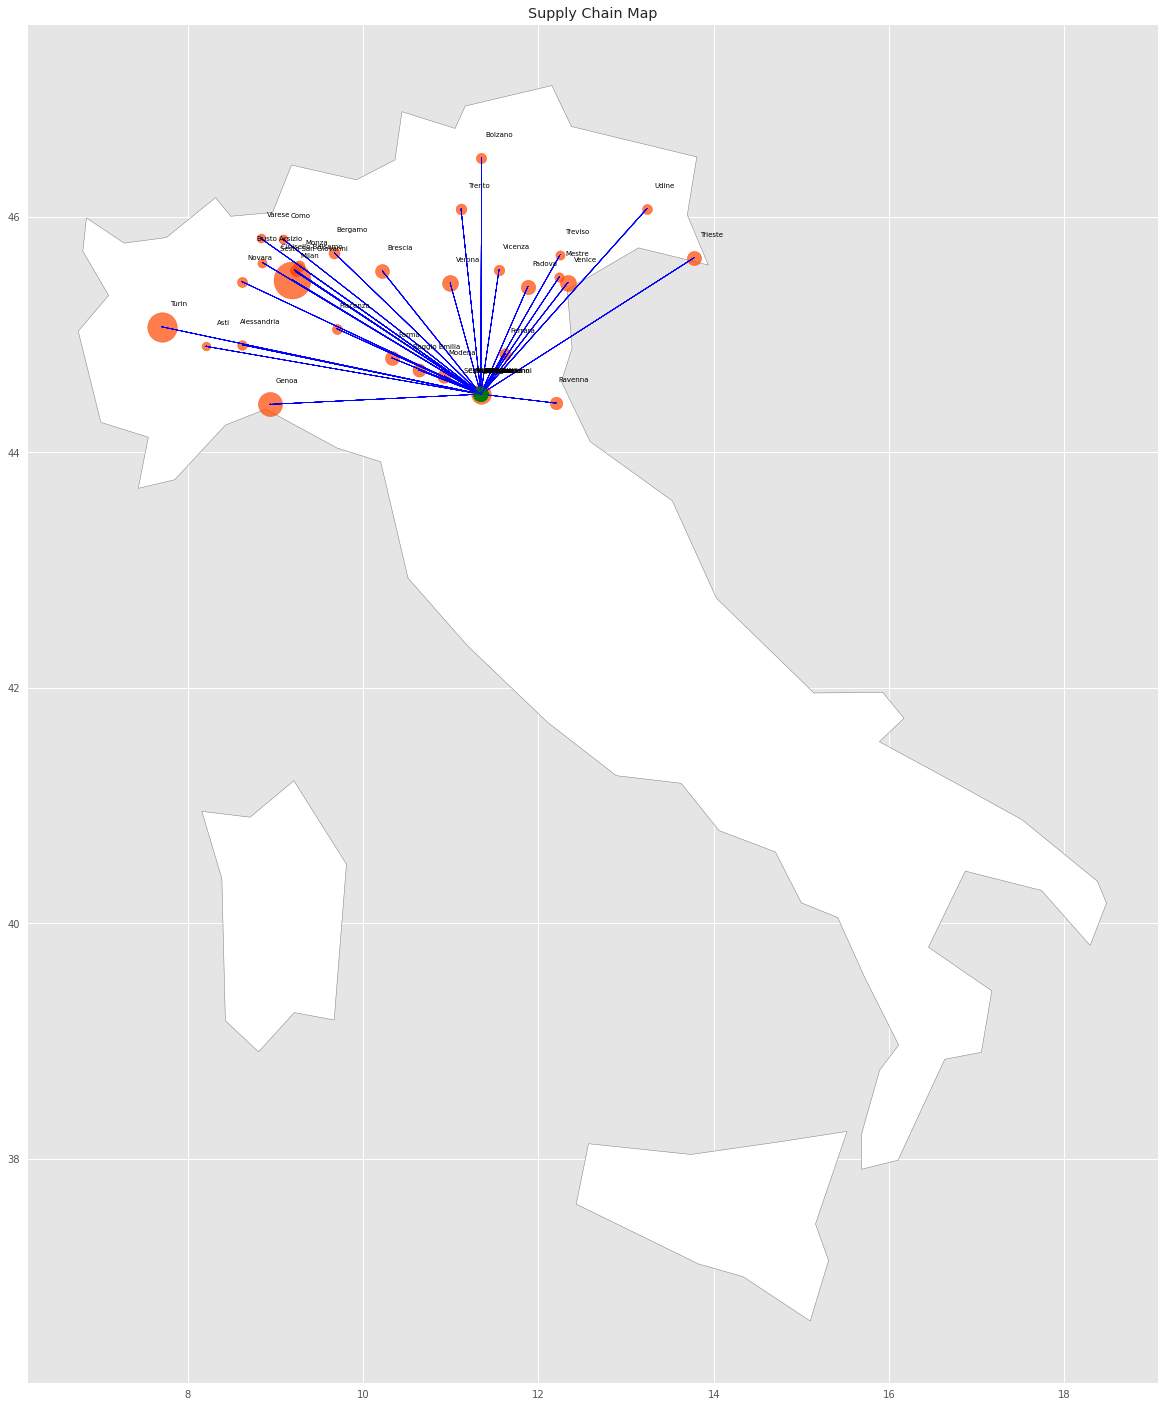

In [23]:
# AS-IS Visualization with Geopandas (one warehouse and 30 customers)

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world.head()

with plt.style.context(("seaborn", "ggplot")):
    ## Plot world
    world[world.name == "Italy"].plot(figsize=(25,25), edgecolor="grey", color="white");                                                                   
    
    ## Loop through each flight plotting line depicting flight between source and destination
    for dlat, dlon, demand, city in zip(cur_customer["Latitude"], cur_customer["Longitude"], cur_customer["Demand"], cur_customer["City"]):
        #plt.plot([dlon,dlat], linewidth=3, color="red", alpha=0.7)
        plt.plot(po_x,po_y, marker='D',linewidth=15,color="green", alpha=0.7)
        plt.scatter(dlon,dlat, color="orangered", alpha=0.7, s=demand)
        plt.plot(x0,y0, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(x1,y1, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(x2,y2, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(x3,y3, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(x4,y4, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(x5,y5, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(x6,y6, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(x7,y7, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(x8,y8, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(x9,y9, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(x10,y10, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(x11,y11, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(x12,y12, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(x13,y13, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(x14,y14, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(x15,y15, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(x16,y16, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(x17,y17, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(x18,y18, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(x19,y19, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(x20,y20, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(x21,y21, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(x22,y22, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(x23,y23, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(x24,y24, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(x25,y25, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(x26,y26, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(x27,y27, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(x28,y28, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(x29,y29, marker=',',linewidth=0.5, color='blue',alpha=0.5)
        
        plt.text(slon+0.2, slat+0.2, city, fontsize=7, color="black", alpha=1, horizontalalignment='center', verticalalignment='center')
        plt.text(dlon+0.2, dlat+0.2, city, fontsize=7, color="black", alpha=1, horizontalalignment='center', verticalalignment='center')

    plt.savefig("additional_materials/figures/1_connection-map-geopandas.png", dpi=400)
    plt.title("Supply Chain Map")

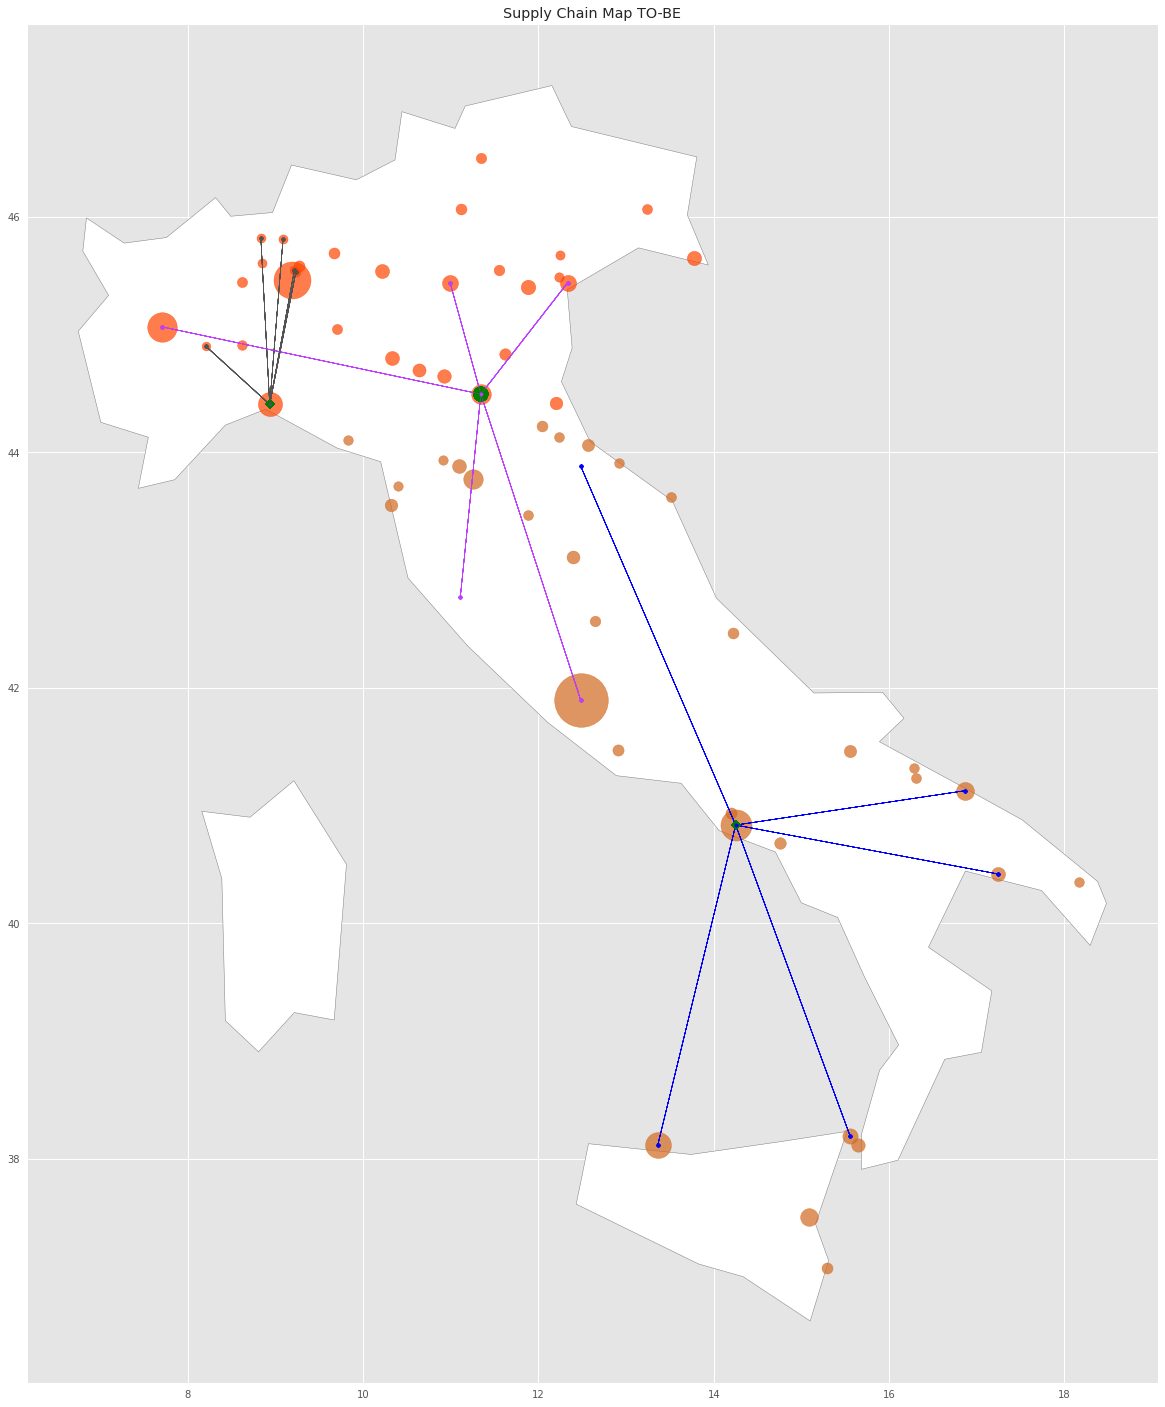

In [33]:
# TO-BE Visualization with Geopandas (three warehouse and 71 customers)

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world.head()

with plt.style.context(("seaborn", "ggplot")):
    ## Plot world
    world[world.name == "Italy"].plot(figsize=(25,25), edgecolor="grey", color="white");                                                                   
    
    ## Loop through each flight plotting line depicting flight between source and destination
    for dlat, dlat1, dlon, dlon1, demand, demand1, city in zip(cur_customer["Latitude"],new_customer["Latitude"], cur_customer["Longitude"],new_customer["Longitude"], cur_customer["Demand"], new_customer["Demand"], cur_customer["City"]):
        #plt.plot([dlon,dlat], linewidth=3, color="red", alpha=0.7)
        plt.plot(po_x,po_y, marker='D',linewidth=15,color="green", alpha=0.7)
        plt.plot(po_x_genova,po_y_genova, marker='D',linewidth=15,color="green", alpha=0.7)
        plt.plot(po_x_napoli,po_y_napoli, marker='D',linewidth=15,color="green", alpha=0.7)
        plt.scatter(dlon,dlat, color="orangered", alpha=0.7, s=demand)
        plt.scatter(dlon1,dlat1, color="#D2691E", alpha=0.7, s=demand1)
        #from genova 
        plt.plot(wc11x, wc11y, marker='.',linewidth=0.5, color='#525252',alpha=0.5)  #gray
        plt.plot(wc12x, wc12y, marker='.',linewidth=0.5, color='#525252',alpha=0.5)
        plt.plot(wc13x, wc13y, marker='.',linewidth=0.5, color='#525252',alpha=0.5)
        plt.plot(wc14x, wc14y, marker='.',linewidth=0.5, color='#525252',alpha=0.5)
        plt.plot(wc15x, wc15y, marker='.',linewidth=0.5, color='#525252',alpha=0.5)
        #from bologna
        plt.plot(wc21x, wc21y, marker='.',linewidth=0.5, color='#BF3EFF',alpha=0.5)   #violet
        plt.plot(wc22x, wc22y, marker='.',linewidth=0.5, color='#BF3EFF',alpha=0.5)
        plt.plot(wc23x, wc23y, marker='.',linewidth=0.5, color='#BF3EFF',alpha=0.5)
        plt.plot(wc24x, wc24y, marker='.',linewidth=0.5, color='#BF3EFF',alpha=0.5)
        plt.plot(wc25x, wc25y, marker='.',linewidth=0.5, color='#BF3EFF',alpha=0.5)
        #from napoli
        plt.plot(wc31x, wc31y, marker='.',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(wc32x, wc32y, marker='.',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(wc33x, wc33y, marker='.',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(wc34x, wc34y, marker='.',linewidth=0.5, color='blue',alpha=0.5)
        plt.plot(wc35x, wc35y, marker='.',linewidth=0.5, color='blue',alpha=0.5)
        
        
        
        #plt.text(slon+0.2, slat+0.2, city, fontsize=7, color="black", alpha=1, horizontalalignment='center', verticalalignment='center')
        #plt.text(dlon+0.2, dlat+0.2, city, fontsize=7, color="black", alpha=1, horizontalalignment='center', verticalalignment='center')

    plt.savefig("additional_materials/figures/2_connection-map-geopandas.png", dpi=400)
    plt.title("Supply Chain Map TO-BE")